# IAPR: Project ‒  Coin Counter


**Group ID:** 12

**Author 1 (sciper):** Vray Alexandre (310104)   
**Author 2 (sciper):** Aellen Edgar (311574)  
**Author 3 (sciper):** Robrdet Alexis (371391)   

**Release date:** 26.04.2024  
**Due date:** 29.05.2024 (11:59 pm)

In [1]:
import cv2
import os

import numpy as np
import pandas as pd
import random
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

from utils.display import plot_images, plot_coins
from utils.localization import localize_coins

import skimage

train_folder = 'data/train'
test_folder = 'data/test'

## Read data

In [2]:
def image_type(row):
    id = int(row['id'][5:])
    if 277 <= id <= 323 or 405 <= id <= 454:
        return 0
    elif 325 <= id <= 370 or 462 <= id <= 503:
        return 1
    else:
        return 2



data = pd.read_csv('data/train_labels.csv').sort_values(by='id')
data['type'] = data.apply(image_type, axis=1)

data

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD,type
6,L1010277,1,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0
10,L1010279,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
0,L1010281,0,0,0,0,2,3,1,0,0,0,0,0,2,0,0,0,0
15,L1010283,0,0,0,1,0,0,0,1,0,2,1,0,1,0,0,0,0
8,L1010287,0,1,1,0,0,0,1,0,0,0,0,2,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,L1010515,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2
74,L1010517,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
78,L1010521,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
80,L1010523,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2


In [3]:
def load_images_from_folder(folder):
    images = []
    for root, _, filenames in sorted(os.walk(folder)):
        for filename in sorted(filenames):
            # id = int(filename[1:8])
            # batch = 2
            # if id<batch*18 or id>=(batch+1)*18:
            #     continue
            img = cv2.imread(os.path.join(root, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return np.array(images)

# Replace 'path_to_your_folder' with the path to the folder containing your images
x = load_images_from_folder(train_folder)
y = data.loc[:,'5CHF':'OOD'].values
types = data['type'].values

random.seed(42)
shuffle = random.sample(range(len(x)), k=len(x))
x = [x[i] for i in shuffle]
y = y[shuffle]
types = types[shuffle]

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
types_train = types[:int(0.8*len(types))]

x_val = x[int(0.8*len(x)):]
y_val = y[int(0.8*len(y)):]
types_val = types[int(0.8*len(types)):]

labels = data.loc[:,'5CHF':'OOD'].columns

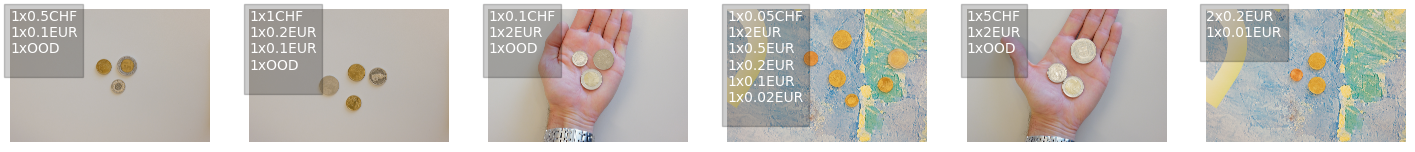

In [4]:
sample = random.sample(range(len(x_train)), k=6)

x_sample = [x_train[sample[i]] for i in range(len(sample))] #[x_val[i] for i in range(len(x_val)) if types_val[i] == 2] #
y_sample = y_train[sample]#y_val[types_val==2] # 

plot_images(images=x_sample, coins=y_sample)

## 1. Localization

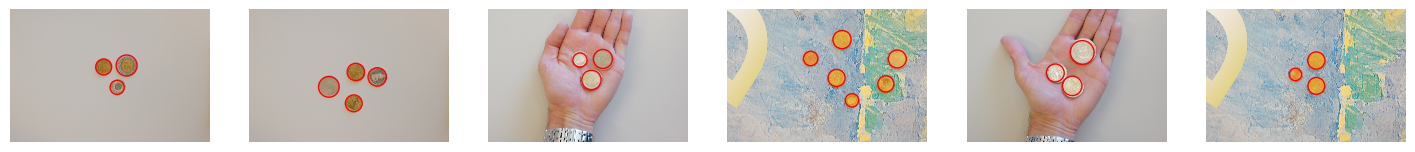

In [5]:
coins_coord = []

for i in range(len(x_sample)):
    coins_coord.append(localize_coins(x_sample[i]))

plot_images(images=x_sample, coins_coord=coins_coord)

## 2. Batch extraction

In [6]:
def extract_coins(images, coins_coord):
    coins = []
    N,M = images[0].shape[:2]

    for i in range(len(images)):
        coins_i = []
        img = images[i]
        centers = coins_coord[i]
        for x,y,r in centers:
            x = int(x)
            y = int(y)
            x = min(M-400,max(400, x))
            y = min(N-400,max(400, y))
            coin = img[y-400:y+400, x-400:x+400]
                
            coins_i.append(coin)
        coins.append(coins_i)
    return coins

coins = extract_coins(x_sample, coins_coord)

## 2.1. Dataset creation

In [7]:
coins_coord = []
for i in range(len(x)):
    coins_coord.append(localize_coins(x[i]))

coins = extract_coins(x, coins_coord)

In [8]:
coins_labels = []
coins_labels.append([labels[2],labels[8],labels[8],labels[11],labels[7],labels[10],labels[10],labels[3],labels[3]])
coins_labels.append([labels[9],labels[12],labels[10],labels[7],labels[3],labels[9]])
coins_labels.append([labels[0]])
coins_labels.append([labels[1],labels[7],labels[9]])
coins_labels.append([labels[1],labels[4],labels[9],labels[8],labels[5],labels[11],labels[3],labels[14]])
coins_labels.append([labels[9],labels[1],labels[11],labels[3]])
coins_labels.append([labels[1],labels[2],labels[5],labels[0],labels[6],labels[6],labels[10],labels[14],labels[14],labels[11],labels[6]])
coins_labels.append([labels[7],labels[7],labels[9],labels[0],labels[-1]])
coins_labels.append([labels[7],labels[7],labels[2],labels[9],labels[13],labels[3],labels[6]])
coins_labels.append([labels[-1],labels[-1],labels[14]])

coins_labels.append([labels[2],labels[12],labels[1],labels[13],labels[11],labels[6],labels[14],labels[11]])
coins_labels.append([labels[7],labels[-1],labels[8]])
coins_labels.append([labels[-1]])
coins_labels.append([labels[5],labels[5],labels[11]])
coins_labels.append([labels[0],labels[8],labels[9],labels[2],labels[9],labels[10],labels[4],labels[3],labels[11]])
coins_labels.append([labels[7],labels[-1],labels[12],labels[13],labels[1]])
coins_labels.append([labels[12],labels[12],labels[-1],labels[13],labels[12],labels[13]])
coins_labels.append([labels[7],labels[11],labels[9],labels[10],labels[13],labels[6]])
coins_labels.append([labels[-1],labels[0],labels[-1],labels[9]])
coins_labels.append([labels[-1],labels[7],labels[9],labels[9]])

coins_labels.append([labels[-1],labels[11],labels[3]])
coins_labels.append([labels[2],labels[2],labels[2],labels[13],labels[3]])
coins_labels.append([labels[6]])
coins_labels.append([labels[9],labels[-1],labels[0]])
coins_labels.append([labels[7],labels[-1],labels[5]])
coins_labels.append([labels[0],labels[0],labels[4],labels[11]])
coins_labels.append([labels[7],labels[10],labels[-1]])
coins_labels.append([labels[0],labels[4],labels[-1],labels[13]])
coins_labels.append([labels[0],labels[10],labels[10],labels[9],labels[7]])
coins_labels.append([labels[2],labels[-1],labels[11],labels[10]])

coins_labels.append([labels[0],labels[11],labels[10],labels[12],labels[7],labels[13],labels[12],labels[13],labels[10]])
coins_labels.append([labels[0],labels[-1],labels[5],labels[13]])
coins_labels.append([labels[2],labels[-1],labels[5],labels[13]])
coins_labels.append([labels[12],labels[12],labels[12]])
coins_labels.append([labels[10],labels[2],labels[-1],labels[14],labels[14],labels[4]])
coins_labels.append([labels[1],labels[7],labels[11],labels[9],labels[9]])
coins_labels.append([labels[0],labels[-1],labels[13]])
coins_labels.append([labels[7],labels[-1],labels[-1]])
coins_labels.append([labels[2],labels[10],labels[5],labels[0],labels[9]])
coins_labels.append([labels[7],labels[1],labels[4],labels[12],labels[13]])

coins_labels.append([labels[10],labels[10],labels[14]])
coins_labels.append([labels[2],labels[-1],labels[12],labels[12],labels[10]])
coins_labels.append([labels[7],labels[0],labels[5],labels[12]])
coins_labels.append([labels[9],labels[12],labels[11],labels[3]])
coins_labels.append([labels[9],labels[12],labels[0],labels[12],labels[14]])
coins_labels.append([labels[4],labels[5],labels[12],labels[5],labels[4],labels[12],labels[6],labels[5]])
coins_labels.append([labels[0],labels[11],labels[11],labels[-1],labels[-1]])
coins_labels.append([labels[1],labels[9],labels[11],labels[7]])
coins_labels.append([labels[9],labels[12],labels[3],labels[14]])
coins_labels.append([labels[0],labels[0],labels[-1]])

coins_labels.append([labels[10],labels[-1]])
coins_labels.append([labels[9],labels[12],labels[8],labels[-1],labels[3],labels[14],labels[1]])
coins_labels.append([labels[7],labels[9],labels[-1],labels[-1]])
coins_labels.append([labels[1],labels[2],labels[5],labels[2]])
coins_labels.append([labels[8],labels[2],labels[10],labels[10]])
coins_labels.append([labels[-1],labels[7],labels[0],labels[12],labels[11],labels[3]])
coins_labels.append([labels[9],labels[0],labels[9],labels[12],labels[8],labels[14],labels[13],labels[13]])
coins_labels.append([labels[1],labels[7],labels[10]])
coins_labels.append([labels[0],labels[1],labels[5],labels[13],labels[-1]])
coins_labels.append([labels[0],labels[7],labels[-1]])

coins_labels.append([labels[1],labels[4],labels[3],labels[5]])
coins_labels.append([labels[7],labels[12],labels[3],labels[13]])
coins_labels.append([labels[-1]])
coins_labels.append([labels[0],labels[-1]])
coins_labels.append([labels[-1],labels[10],labels[-1],labels[10],labels[12]])
coins_labels.append([labels[2],labels[1],labels[9],labels[-1],labels[6]])
coins_labels.append([labels[11],labels[14],labels[6]])
coins_labels.append([labels[0],labels[7],labels[0],labels[-1],labels[7],labels[9],labels[13],labels[-1]])
coins_labels.append([labels[2],labels[10],labels[4],labels[5],labels[6],labels[14]])
coins_labels.append([labels[-1],labels[6],labels[3],labels[5],labels[11]])

coins_labels.append([labels[0],labels[7],labels[-1]])
coins_labels.append([labels[8],labels[7],labels[9],labels[7],labels[5],labels[4],labels[12],labels[3],
                    labels[0],labels[-1],labels[6],labels[11],labels[13],labels[12],labels[6],labels[14],
                    labels[13]])
coins_labels.append([labels[1],labels[2],labels[-1],labels[13],labels[6]])
coins_labels.append([labels[1],labels[2],labels[3],labels[3],labels[1]])
coins_labels.append([labels[1],labels[1],labels[9],labels[12],labels[10],labels[6],labels[-1],labels[14]])
coins_labels.append([labels[1],labels[7],labels[2],labels[1],labels[10],labels[11]])
coins_labels.append([labels[9],labels[10],labels[10],labels[11]])
coins_labels.append([labels[-1]])
coins_labels.append([labels[-1],labels[-1],labels[9]])
coins_labels.append([labels[8],labels[7],labels[9],labels[11],labels[12],labels[10],labels[13],labels[14]])

coins_labels.append([labels[-1],labels[-1]])



In [9]:
coins_list = [coin for coins_img in coins for coin in coins_img]
labels_list = [label for labels_img in coins_labels for label in labels_img]

# Save images
for i, image in enumerate(coins_list):
    cv2.imwrite(f"data/train_coins/image_{i}.jpg", image)

# Create DataFrame for labels
df_labels = pd.DataFrame({"labels": labels_list,
                          "image": [f"image_{i}.jpg" for i in range(len(labels_list))]
                        })

# Save labels to CSV
df_labels.to_csv("data/train_coins/labels.csv", index=False)
